# Unsupervised Models

In [1]:
import functools
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import k_means, dbscan
from sklearn.mixture import GaussianMixture
import fastcluster
from scipy.cluster.hierarchy import fcluster
import hdbscan 
from sklearn_som.som import SOM

In [2]:
X_small_path = 'data/unsupervised/small/graph.data.gz'
y_small_path = 'data/unsupervised/small/graph.labels0.gz'
X_large_path = 'data/unsupervised/large/h2mg_128_60.data.gz'
y_large_path = 'data/unsupervised/large/h2mg_128_60.labels0.gz'


def load_data(X_path, y_path):
    X = np.loadtxt(X_path)
    y = np.loadtxt(y_path) - 1
    clusters, cluster_counts = np.unique(y, return_counts=True)
    n_clusters = len(clusters)
    return X, y, clusters, cluster_counts, n_clusters


## Small dataset

In [3]:
X_small, y_small, clusters_small, cluster_counts_small, n_clusters_small = load_data(X_small_path, y_small_path)

print(n_clusters_small)
print(clusters_small)
print(cluster_counts_small)

10
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
[250 250 250 250 250 250 250 250 250 250]


In [4]:
def gmm_(X: np.ndarray, n_clusters: int, **kwargs) -> np.ndarray:
    return GaussianMixture(n_components=n_clusters, **kwargs).fit_predict(X)


def hdbscan_(X: np.ndarray, cluster_selection_epsilon=0., **kwargs) -> np.ndarray:
    return hdbscan.hdbscan(X, cluster_selection_epsilon=cluster_selection_epsilon, **kwargs)[0]


def k_means_(X: np.ndarray, n_clusters: int, **kwargs) -> np.ndarray:
    return k_means(X, n_clusters, **kwargs)[1]


def dbscan_(X: np.ndarray, eps=0.5, **kwargs) -> np.ndarray:
    return dbscan(X, eps, **kwargs)[1]


def som_(X: np.ndarray, m=3, n=3, **kwargs) -> np.ndarray:
    return SOM(m=m, n=n, dim=X.shape[1], **kwargs).fit_predict(X)


def linkager_to_clusterer(linkager):
    def clusterer(X, n_clusters, **kwargs):
        return fcluster(linkager(X, **kwargs), n_clusters, criterion='maxclust')
    return clusterer

hac_single_ = linkager_to_clusterer(fastcluster.single)
hac_average_ = linkager_to_clusterer(fastcluster.average)
hac_complete_ = linkager_to_clusterer(fastcluster.complete)
hac_ward_ = linkager_to_clusterer(fastcluster.ward)


def timed(func):
    @functools.wraps(func)
    def timed_func(*args, **kwargs):
        start_time = time.perf_counter()
        func_ret = func(*args, **kwargs)
        end_time = time.perf_counter()
        time_delta = end_time - start_time
        return func_ret, time_delta
    return timed_func

In [5]:
scoring = {
    'ARI': metrics.adjusted_rand_score,
    'AMI': metrics.adjusted_mutual_info_score,
    'V-measure': metrics.v_measure_score
}

In [6]:
def cluster(X, n_clusters, m, n, eps, cluster_selection_epsilon):
    return {
        'K-Means': timed(k_means_)(X, n_clusters),
        'HAC_Single': timed(hac_single_)(X, n_clusters),
        'HAC_Average': timed(hac_average_)(X, n_clusters),
        'HAC_Complete': timed(hac_complete_)(X, n_clusters),
        'HAC_Ward': timed(hac_ward_)(X, n_clusters),
        'GMM': timed(gmm_)(X, n_clusters),
        'DBSCAN': timed(dbscan_)(X, eps),
        'HDBSCAN': timed(hdbscan_)(X, cluster_selection_epsilon),
        'SOM': timed(som_)(X, m=m, n=n)
    }

For DBSCAN and HDBSCAN we need 10 + 1 = 11 classes (1 is for the noise). We try different hyperparameter values, so that we get this number. We find that `eps=1.81, cluster_selection_epsilon=1.935` give us 11 classes.

In [7]:
# for eps in np.linspace(0, 3, 300)[1:]:
#     print(eps, len(np.unique(dbscan_(X_small, eps=eps))))
#
# for cse in np.linspace(0, 3, 300):    
#     print(cse, len(np.unique(hdbscan_(X_small, cluster_selection_epsilon=float(cse)))))
#
# # eps=1.81, cluster_selection_epsilon=1.935

In [8]:
res_small_timed = cluster(X_small, n_clusters_small, m=2, n=5, eps=1.81, cluster_selection_epsilon=1.935)
res_small = {name: v[0] for name, v in res_small_timed.items()}
times_small = {name: v[1] for name, v in res_small_timed.items()}

# print('| Model | Time (seconds) |')
# print('| --- | --- |')
# print(*(f'| {model} | {t:.3f} |' for model, t in times_small.items()), sep='\n')

Times needed to cluster the small data

| Model | Time (seconds) |
| --- | --- |
| K-Means | 0.104 |
| HAC_Single | 0.024 |
| HAC_Average | 0.037 |
| HAC_Complete | 0.037 |
| HAC_Ward | 0.044 |
| GMM | 0.071 |
| DBSCAN | 0.030 |
| HDBSCAN | 0.042 |
| SOM | 0.194 |

## Visualizing the clusters

We can see that there is no obvious way to cluster our data. The results of each algorithm make sense when visualized, they just don't all cluster them the way we would want. 

The best result is definitely GMM, by each of the three metrics. When visualized, we can see that it almost perfectly matches our original cluster pattern. 

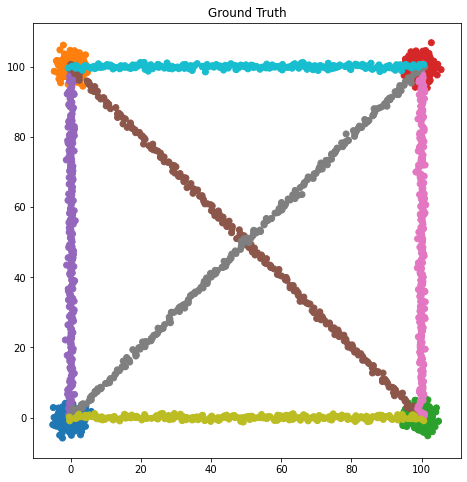

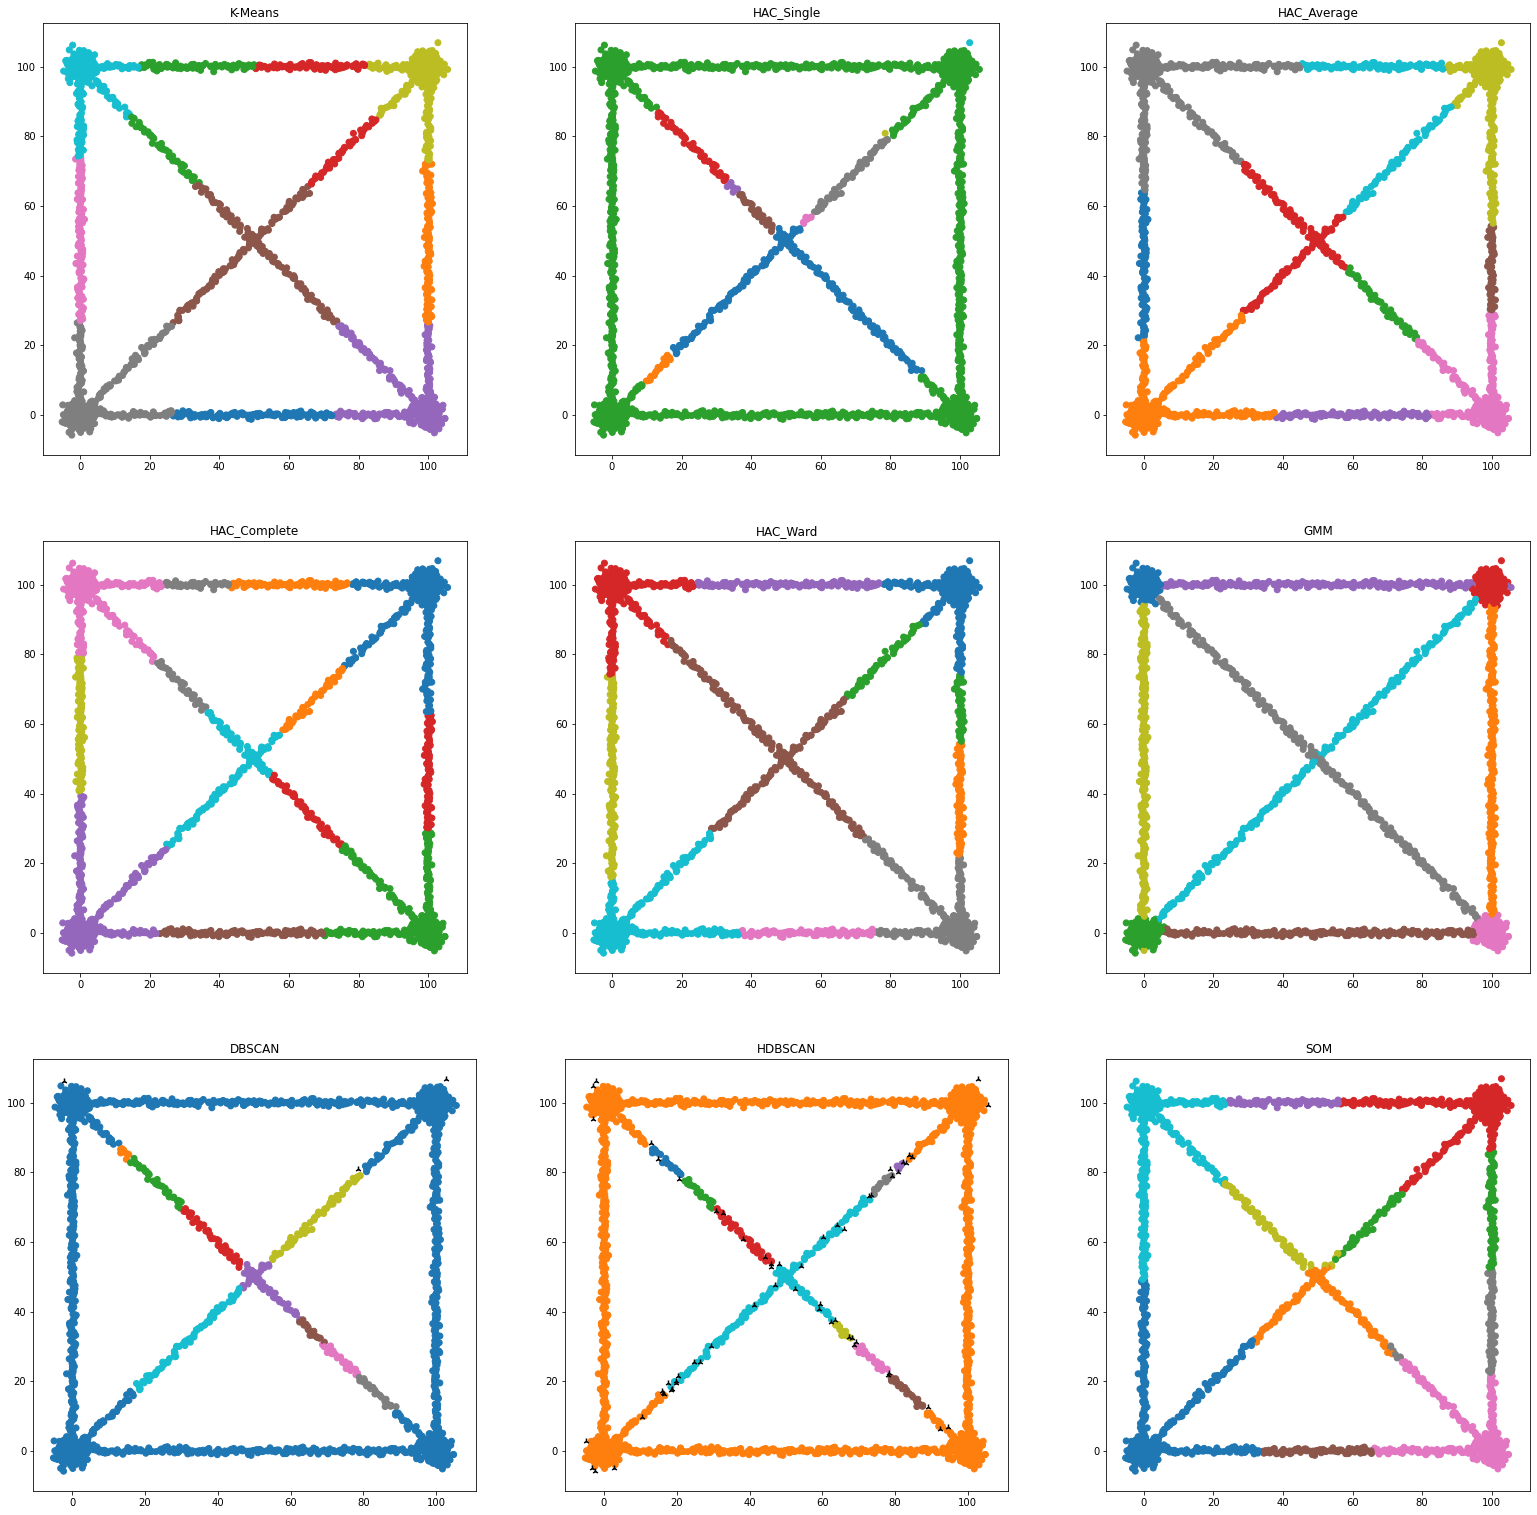

In [9]:
def plot_clusters(X, z, title=None, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(X[:,0], X[:,1], c=z, cmap='tab10')
    ax.set_aspect('equal', 'box')
    ax.set_title(title)


def plot_dbscan(X, z, title=None, ax=None):
    noise = z == -1
    if ax is None:
        _, ax = plt.subplots(figsize=(20, 20))
    ax.scatter(X[~noise, 0], X[~noise, 1], c=z[~noise], cmap='tab10')
    ax.scatter(X[noise, 0], X[noise, 1], c='k', alpha=1.0, marker='2')
    ax.set_title(title)


def plot_clusters_grid(X, zs: dict):
    # add the original cluster as well
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(27, 27))
    for (name, z), ax in zip(zs.items(), axs.flat):
        if name in ('DBSCAN', 'HDBSCAN'):
            plot_dbscan(X, z, title=name, ax=ax)
        else:
            plot_clusters(X, z, title=name, ax=ax)


plot_clusters(X_small, y_small, title='Ground Truth')
plot_clusters_grid(X_small, res_small)

plt.show()

In [10]:
def get_scores(zs, z_true, scoring):
    scores = {}
    for model_name, z in zs.items():
        scores[model_name] = {}
        for score_name, scorer in scoring.items():
            scores[model_name][score_name] = scorer(z_true, z)
    return scores

In [11]:
scores_small = get_scores(res_small, y_small, scoring)

# print(f'| Model | {" | ".join(scoring)} |')
# print('|' + (1+len(scoring)) * ' --- |')
# for model_name, d in scores_small.items():
#     print(f'| {model_name} | ', end='')
#     print(' | '.join("{:.4f}".format(x) for x in d.values()), end=' |\n')

Small data clustering scores

| Model | ARI | AMI | V-measure |
| --- | --- | --- | --- |
| K-Means | 0.4419 | 0.6374 | 0.6400 |
| HAC_Single | 0.0347 | 0.2296 | 0.2378 |
| HAC_Average | 0.4075 | 0.6219 | 0.6248 |
| HAC_Complete | 0.4032 | 0.6049 | 0.6078 |
| HAC_Ward | 0.4580 | 0.6539 | 0.6565 |
| GMM | 0.8643 | 0.8872 | 0.8880 |
| DBSCAN | 0.0284 | 0.2316 | 0.2416 |
| HDBSCAN | 0.0327 | 0.2193 | 0.2297 |
| SOM | 0.3667 | 0.5887 | 0.5919 |

We will use ARI to order our models from best to worst.

In [12]:
def order_models(scores, metric):
    return sorted(
        ((model_name, d[metric]) for model_name, d in scores.items()),
        key=lambda v: v[1], reverse=True
    )

In [13]:
order_small = order_models(scores_small, 'ARI')
order_small

[('GMM', 0.8634437651577802),
 ('HAC_Ward', 0.45803780437166225),
 ('K-Means', 0.4418983338827541),
 ('HAC_Average', 0.40752252855526977),
 ('HAC_Complete', 0.40323107839150135),
 ('SOM', 0.37782370722422204),
 ('HAC_Single', 0.03474174705316093),
 ('HDBSCAN', 0.032659061482118494),
 ('DBSCAN', 0.02843084031409717)]

## Plotting the contingency tables


A confusion matrix is used only for supervised problems. It's not supposed to be used for unsupervised problems. There's two reason for this:
* Confusion matrix compares label names, while in unsupervised problems we don't care about the cluster names. We could have labels ['a', 'b', ... ] instead of [0, 1, ... ] for example.
* In addition to that, if our predicted clusters were not equal in number to the original ones, then we can't have a confusion matrix.

The concept we are looking for is the **Contingency Table** (of which the *Confusion Matrix* is a special case). And that's what we are going to plot. 

**Ideally we would have the same clusters up to a permutation of their names**. This means that ideally we would expect a permutation of the diagonal matrix (equivalently: one big number on each row). We see that our best results are similar to our ideal type of matrix.

The GMM algorithm is definitely the best one, by all metrics. 

In [14]:
def plot_contingency_matrices(zs, z_true, order, suptitle=None) -> None:

    
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(16, 16))
    
    for (name, acc), ax in zip(order, axs.flat):
        z = zs[name]
        contingency_matrix = metrics.cluster.contingency_matrix(z_true, z)
        sns.heatmap(
            contingency_matrix,
            annot=True,
            cmap='viridis',
            fmt='d',
            cbar=False,
            ax=ax
        )
        ax.axis('off')
        ax.set_title(f'{name} ({acc:.4f})')

    fig.suptitle(suptitle)

    

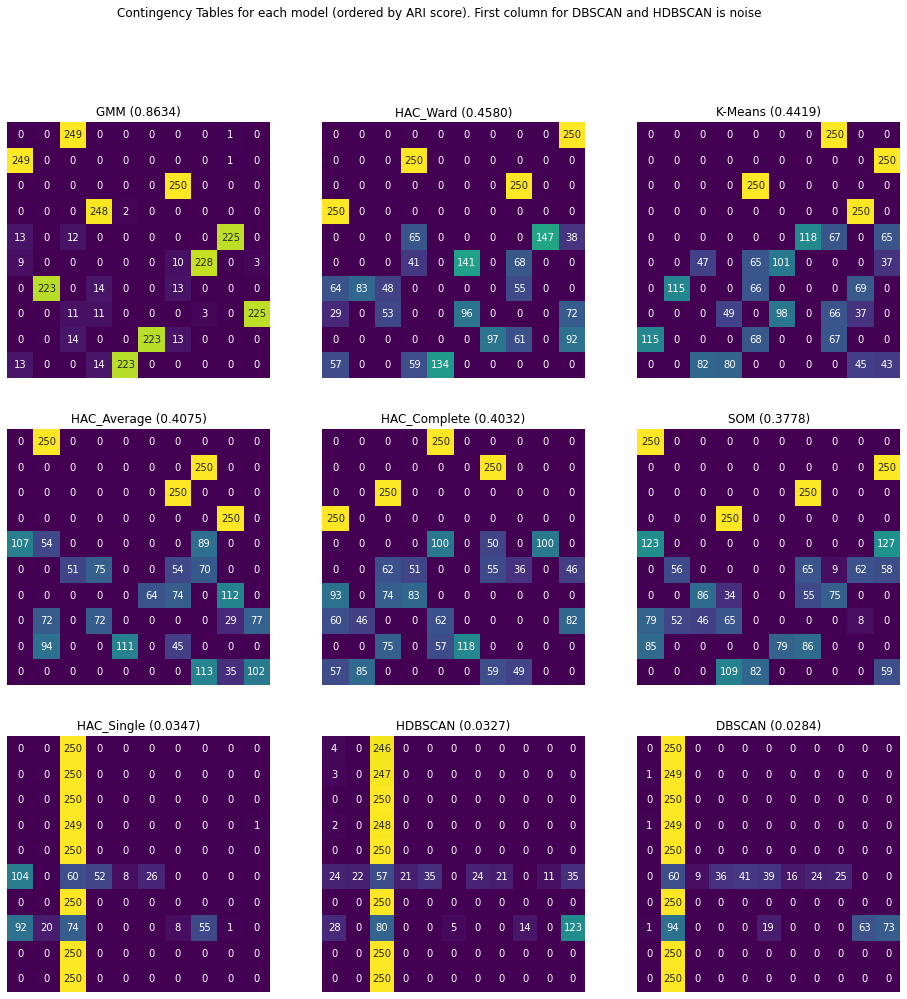

In [15]:
plot_contingency_matrices(res_small, y_small, order_small,
                        suptitle='Contingency Tables for each model (ordered by ARI score). First column for DBSCAN and HDBSCAN is noise')

## Large dataset

In [16]:
X_large, y_large, clusters_large, cluster_counts_large, n_clusters_large = load_data(X_large_path, y_large_path)

print(n_clusters_large)
print(clusters_large)
print(cluster_counts_large)

2
[0. 1.]
[1024 1024]


`eps=50.0, cluster_selection_epsilon=0.` give 2+1 labels

In [17]:
# for eps in np.linspace(0, 100, 300)[1:]:
#     print(eps, len(np.unique(dbscan_(X_large, eps=eps))))
#
# for cse in np.linspace(0, 100, 300):    
#     print(cse, len(np.unique(hdbscan_(X_large, cluster_selection_epsilon=float(cse)))))
#
# # eps=50.0 gives 2+1 labels
# # cluster_selection_epsilon=0.0 gives 2+1 labels

In [18]:
res_large_timed = cluster(X_large, n_clusters_large, m=2, n=1, eps=50.0, cluster_selection_epsilon=0.0)
res_large = {name: v[0] for name, v in res_large_timed.items()}
times_large = {name: v[1] for name, v in res_large_timed.items()}

# print('| Model | Time (seconds) |')
# print('| --- | --- |')
# print(*(f'| {model} | {t:.3f} |' for model, t in times_large.items()), sep='\n')

| Model | Time (seconds) |
| --- | --- |
| K-Means | 0.135 |
| HAC_Single | 0.134 |
| HAC_Average | 0.123 |
| HAC_Complete | 0.110 |
| HAC_Ward | 0.101 |
| GMM | 0.023 |
| DBSCAN | 0.066 |
| HDBSCAN | 0.619 |
| SOM | 0.236 |

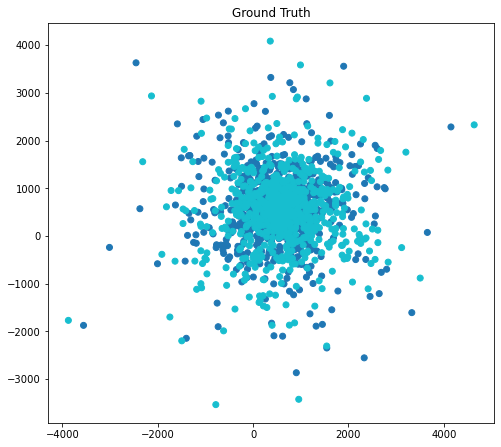

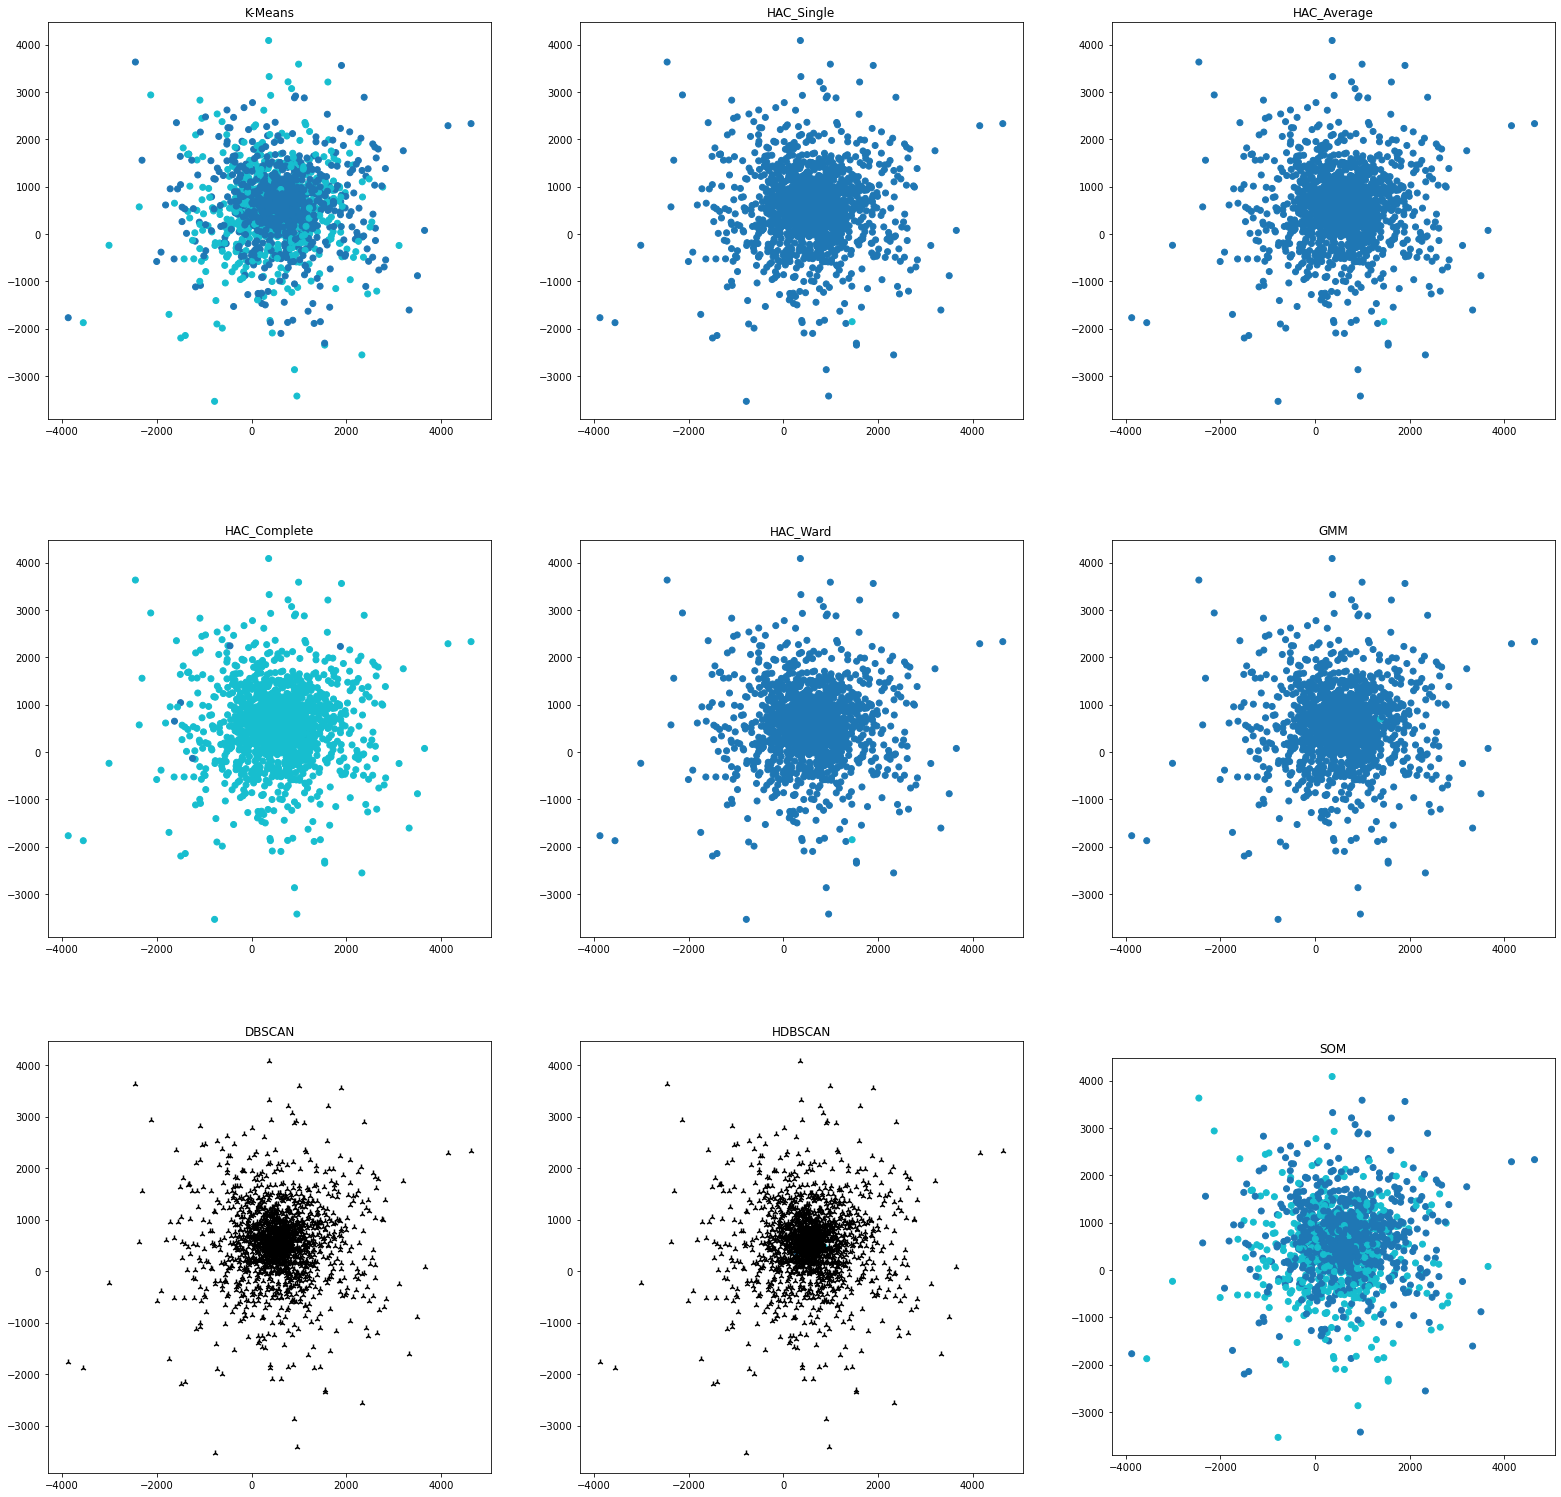

In [19]:
plot_clusters(X_large, y_large, title='Ground Truth')
plot_clusters_grid(X_large, res_large)
plt.show()

In [20]:
scores_large = get_scores(res_large, y_large, scoring)

# print(f'| Model | {" | ".join(scoring)} |')
# print('|' + (1+len(scoring)) * ' --- |')
# for model_name, d in scores_large.items():
#     print(f'| {model_name} | ', end='')
#     print(' | '.join("{:.4f}".format(x) for x in d.values()), end=' |\n')

| Model | ARI | AMI | V-measure |
| --- | --- | --- | --- |
| K-Means | 0.0062 | 0.0126 | 0.0130 |
| HAC_Single | 0.0000 | 0.0000 | 0.0010 |
| HAC_Average | 0.0000 | 0.0000 | 0.0010 |
| HAC_Complete | -0.0000 | -0.0008 | 0.0000 |
| HAC_Ward | 0.0000 | 0.0000 | 0.0010 |
| GMM | -0.0000 | -0.0007 | 0.0002 |
| DBSCAN | 0.0000 | 0.0114 | 0.0128 |
| HDBSCAN | 0.0145 | 0.1457 | 0.1465 |
| SOM | 0.0182 | 0.0132 | 0.0136 |

In [21]:
order_large = order_models(scores_large, 'ARI')
order_large

[('K-Means', 0.5051904055516337),
 ('SOM', 0.15219249110256955),
 ('HDBSCAN', 0.014463117504770447),
 ('DBSCAN', 3.344100869442605e-05),
 ('HAC_Single', 0.0),
 ('HAC_Average', 0.0),
 ('HAC_Ward', 0.0),
 ('GMM', 0.0),
 ('HAC_Complete', -5.708101817516085e-06)]

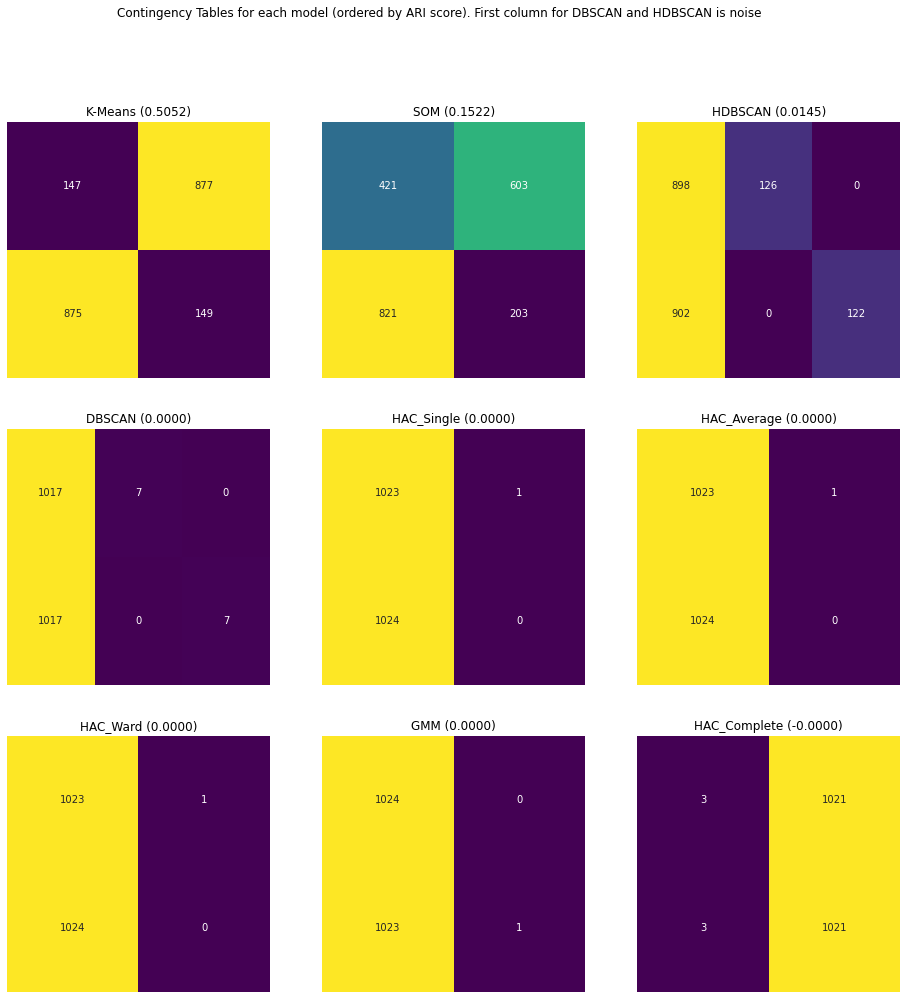

In [22]:
plot_contingency_matrices(res_large, y_large, order_large,
                        suptitle='Contingency Tables for each model (ordered by ARI score). First column for DBSCAN and HDBSCAN is noise')

## Remarks

As we can see there is huge overlap in our data. It's futile to try to put them into two separate clusters. The scores of our metrics and the contingency tables show us just that.